In [1]:
# Reading the unmodified raw transcations data and product category labels
data_trans <- arules::read.transactions("../../data/raw/trans.csv", sep=',', format='basket', header=TRUE)
data_cat <- read.csv('../../data/clean/product_categories.csv')

In [2]:
arules::inspect(head(data_trans))

    items                                    
[1] {IFX0014,IFX0049,MOP0083,TUC0302}        
[2] {APP1130,CRU0045,OWC0048,SEA0038}        
[3] {APP0405,APP1208}                        
[4] {APP0432,APP1457,APP2487,APP2552,BOS0059}
[5] {APP1208,APP1459,ELA0004,LAC0221,LGE0038}
[6] {APP1916,APP2498}                        


In [3]:
# Adding item group category from categories extracted from the pdf. Some missing values for categories
items <- arules::itemInfo(data_trans)
names(data_cat) <- c('labels', 'level1')
items_with_cat <- merge(x=items, y=data_cat, by = "labels", all.x=TRUE)
summary(items_with_cat)
head(items_with_cat)

# assigning the labels to the data
arules::itemInfo(data_trans) <- items_with_cat

    labels                  level1    
 Length:4247        accessories:3358  
 Class :character   pc         : 181  
 Mode  :character   laptop     : 148  
                    other      : 112  
                    tablet     : 112  
                    (Other)    : 296  
                    NA's       :  40  

labels,level1
<chr>,<fct>
8MO0001,accessories
8MO0002,accessories
8MO0003,accessories
8MO0004,accessories
8MO0005,accessories
8MO0006,accessories


In [4]:
# Data is of the size that we expect
length(data_trans)

[1] 10453

In [5]:
# How many items does one transaction represent
summary(arules::size(data_trans))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   2.000   2.487   3.000  13.000 

In [6]:
# item labels
length(arules::itemLabels(data_trans))
# there are massive amount of unique items considering that we only have a bit over 10000 transactions. This will be a problem

[1] 4247

[1] 1

[1] 290

[1] 6.120085

[1] 2

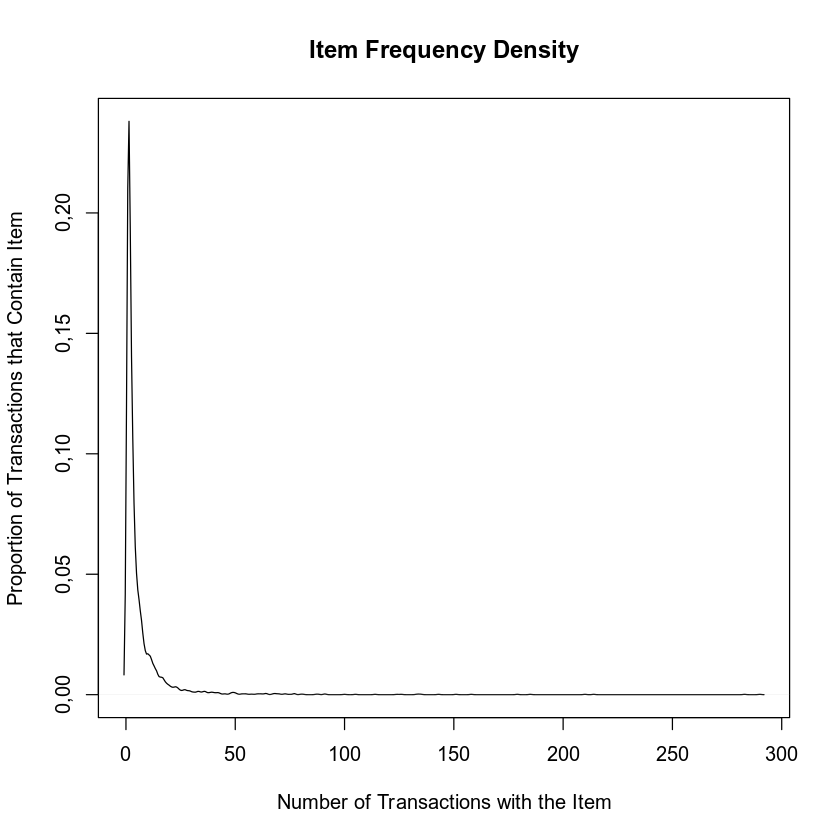

In [7]:
# Most of the items only appear only in few transactions, with a clear median of 2 (check plot below)
item_freq <- arules::itemFrequency(data_trans, type='absolute')
min(item_freq)
max(item_freq)
mean(item_freq)
median(item_freq)
plot(density(item_freq), main = 'Item Frequency Density', ylab = "Proportion of Transactions that Contain Item", xlab="Number of Transactions with the Item")

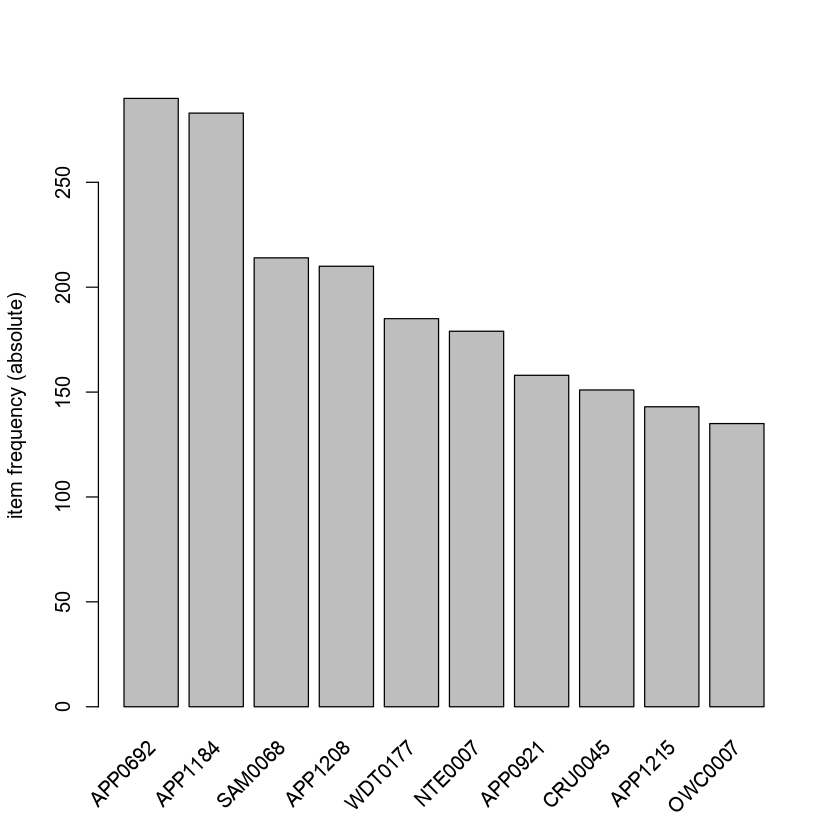

In [8]:
# Even for top items combinations the frequencies are quite low compared to the number of transactions
arules::itemFrequencyPlot(data_trans, type='absolute', topN=10)

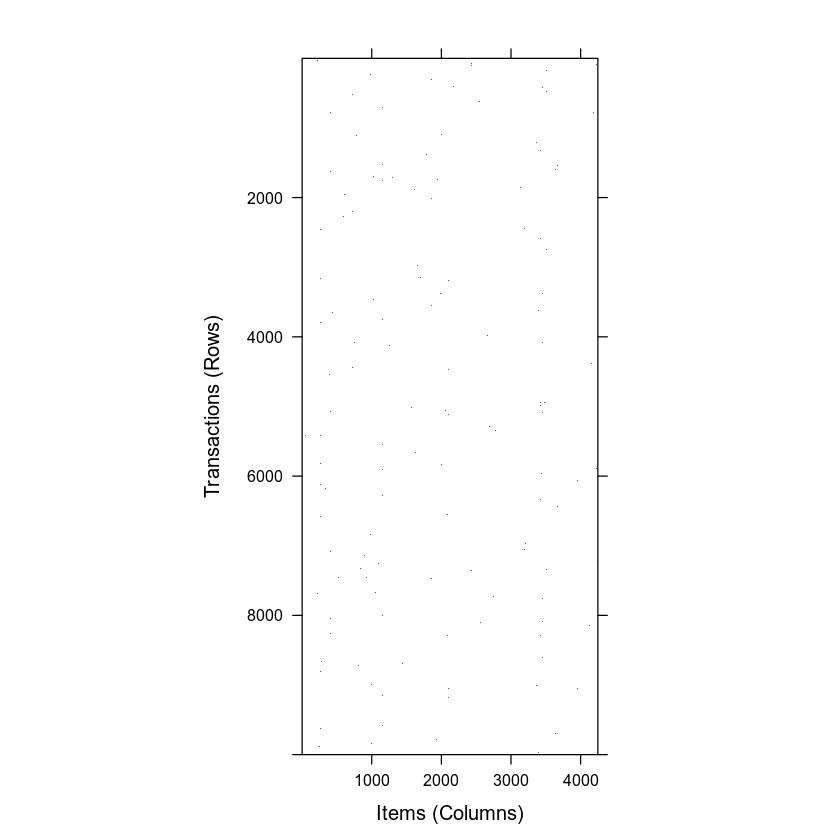

In [9]:
# There are so many different items and the items are quite rare, that transactions with items does not give much information 
# We must look elsewhere for a good visualization of the dataset
arules::image(sample(data_trans, 10000))

In [10]:
# The support and confidence must be tuned wery low to see a meaningful number of rules
rules <- arules::apriori(data_trans, parameter=list(support=0.001, confidence=0.5, target='rules'))
rules

# Removing redundant and non-significant rules
rules <- rules[!arules::is.redundant(rules)]
rules <- rules[arules::is.significant(rules, data_trans, method='chisq', alpha=0.001, adjust='bonferroni')]

# We are only finding rules that map one item to another. More complex pattern are too rare.
# This also means that there are no redundant rules
arules::inspect(rules)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0,5    0,1    1 none FALSE            TRUE       5   0,001      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0,1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 10 

set item appearances ...[0 item(s)] done [0,00s].
set transactions ...[4247 item(s), 10453 transaction(s)] done [0,02s].
sorting and recoding items ... [591 item(s)] done [0,00s].
creating transaction tree ... done [0,00s].
checking subsets of size 1 2 3 done [0,00s].
writing ... [12 rule(s)] done [0,00s].
creating S4 object  ... done [0,00s].


set of 12 rules 

     lhs          rhs       support     confidence lift      count
[1]  {SPH0016} => {SPH0015} 0,001052329 0,6470588  338,18529 11   
[2]  {SPH0015} => {SPH0016} 0,001052329 0,5500000  338,18529 11   
[3]  {QNA0210} => {WDT0177} 0,001147996 0,5714286   32,28726 12   
[4]  {SYN0180} => {WDT0177} 0,001243662 0,5652174   31,93631 13   
[5]  {APP2142} => {APP1215} 0,001147996 0,5454545   39,87158 12   
[6]  {SYN0181} => {WDT0177} 0,001339328 0,5000000   28,25135 14   
[7]  {APP2485} => {APP1184} 0,001052329 0,5500000   20,31502 11   
[8]  {APP2117} => {APP1215} 0,001530661 0,6666667   48,73193 16   
[9]  {APP1914} => {APP1041} 0,001147996 0,5217391  165,26482 12   
[10] {APP1803} => {APP1215} 0,001626327 0,8947368   65,40339 17   
[11] {APP2155} => {APP1215} 0,002582991 0,5510204   40,27844 27   
[12] {APP0979} => {APP0692} 0,004496317 0,6103896   22,00139 47   


In [11]:
# Visualizing the rules
library(arulesViz)
plot(rules)
plot(rules, method='graph')
plot(rules, method='grouped matrix')

ERROR: Error in plot.associations(rules): Needed package 'arulesViz' not installed or loaded!


In [12]:
# Trying to use product categories instead of the actual products
data_trans_multlev <- arules::aggregate(data_trans, by="level1")

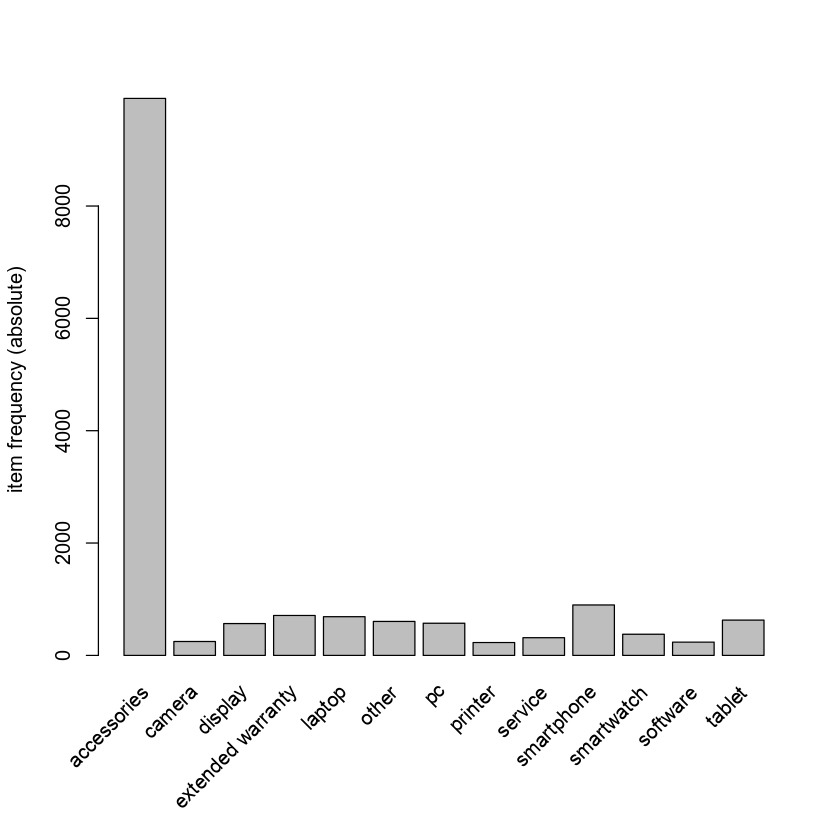

In [13]:
# Accessories are the dominating category with items from it being contained in around half of the transactions
arules::itemFrequencyPlot(data_trans_multlev, type='absolute')

In [14]:
# We need to set the bar support quite high, even though 0.01 would still be over 100 transactions. 
# This is because the computation becomes too demanding without the pruning that is done with the support criteria.

# We do not want the accessories and extended warranty to be in the left hand side, because probably people decide first on 
# some big item and then buy accesories and warranties to that item and not the other way around

# We also limit the number of item categories to use per rule to 3 as we want the rules to be understandable as 
# the intention is to create a readable report and not a recommendation algoritm
rules_multlev <- arules::apriori(
    data_trans_multlev, 
    parameter=list(
        support=0.018, 
        confidence=0.95, 
        minlen=2, 
        maxlen=3,
        target='rules'
    ),
    appearance=list(
        both=c(
            "camera",
            "display",
            "laptop",
            "other",
            "pc",
            "printer",
            "service",
            "smartphone",
            "smartwatch",
            "software",
            "tablet"
        )
    )
)

# Dropping redundant, statistically non-significant rules and rules with less than 10 lift
rules_multlev <- rules_multlev[!arules::is.redundant(rules_multlev)]
rules_multlev <- rules_multlev[arules::is.significant(rules_multlev, data_trans_multlev, method='chisq', alpha=0.001, adjust='bonferroni')]
rules_multlev <- arules::subset(rules_multlev, lift >= 10)

arules::inspect(head(rules_multlev))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0,95    0,1    1 none FALSE            TRUE       5   0,018      2
 maxlen target   ext
      3  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0,1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 188 

set item appearances ...[11 item(s)] done [0,00s].
set transactions ...[11 item(s), 10453 transaction(s)] done [0,00s].
sorting and recoding items ... [11 item(s)] done [0,00s].
creating transaction tree ... done [0,00s].
checking subsets of size 1 2 3

Warning message in arules::apriori(data_trans_multlev, parameter = list(support = 0,018, :
“Mining stopped (maxlen reached). Only patterns up to a length of 3 returned!”

 done [0,01s].
writing ... [398 rule(s)] done [0,00s].
creating S4 object  ... done [0,00s].
    lhs                   rhs        support    confidence lift     count
[1] {camera,printer}   => {software} 0,01970726 1          44,29237 206  
[2] {printer,software} => {camera}   0,01970726 1          42,31984 206  
[3] {camera,software}  => {printer}  0,01970726 1          45,64629 206  
[4] {camera,printer}   => {service}  0,01970726 1          33,18413 206  
[5] {printer,service}  => {camera}   0,01970726 1          42,31984 206  
[6] {camera,service}   => {printer}  0,01970726 1          45,64629 206  


In [15]:
# Visualizing the rules
library(arulesViz)
plot(rules_multlev)
plot(rules_multlev, method='graph')
plot(rules_multlev, method='grouped matrix')

ERROR: Error in plot.associations(rules_multlev): Needed package 'arulesViz' not installed or loaded!


In [69]:
rules_multlev_high_profit <- arules::apriori(
    data_trans_multlev, 
    parameter=list(
        support=0.01, 
        confidence=0.2, 
        minlen=2, 
        maxlen=4,
        target='rules'
    ),
    appearance=list(
        rhs=c(
            "display",
            "laptop",
            "smartphone",
            "software",
            "tablet",
            "printer"
        ),
        default='lhs'
    )
)

# Dropping redundant, statistically non-significant rules and rules with less than 2 lift
rules_multlev_high_profit <- rules_multlev_high_profit[!arules::is.redundant(rules_multlev_high_profit)]
rules_multlev_high_profit <- rules_multlev_high_profit[arules::is.significant(rules_multlev_high_profit, data_trans_multlev, method='chisq', alpha=0.001, adjust='bonferroni')]
rules_multlev_high_profit <- arules::subset(rules_multlev_high_profit, lift >= 10)

arules::inspect(head(rules_multlev_high_profit))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0,2    0,1    1 none FALSE            TRUE       5    0,01      2
 maxlen target   ext
      4  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0,1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 104 

set item appearances ...[6 item(s)] done [0,00s].
set transactions ...[13 item(s), 10453 transaction(s)] done [0,00s].
sorting and recoding items ... [13 item(s)] done [0,00s].
creating transaction tree ... done [0,00s].
checking subsets of size 1 2 3 4

Warning message in arules::apriori(data_trans_multlev, parameter = list(support = 0,01, :
“Mining stopped (maxlen reached). Only patterns up to a length of 4 returned!”

 done [0,00s].
writing ... [372 rule(s)] done [0,00s].
creating S4 object  ... done [0,00s].
    lhs                    rhs       support    confidence lift     count
[1] {camera}            => {printer} 0,01970726 0,8340081  38,06937 206  
[2] {service}           => {printer} 0,01970726 0,6539683  29,85122 206  
[3] {smartwatch}        => {printer} 0,01970726 0,5464191  24,94200 206  
[4] {other}             => {printer} 0,01989859 0,3438017  15,69327 208  
[5] {pc}                => {printer} 0,01970726 0,3595113  16,41036 206  
[6] {extended warranty} => {printer} 0,01970726 0,2897328  13,22523 206  


In [72]:
# removing rules that contain accessories, service, other, or extended warranty on the left hand side
rules_multlev_high_profit_subset <- subset(rules_multlev_high_profit, !(lhs %in% c("accessories", "service", "extended warranty", "other")));

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.


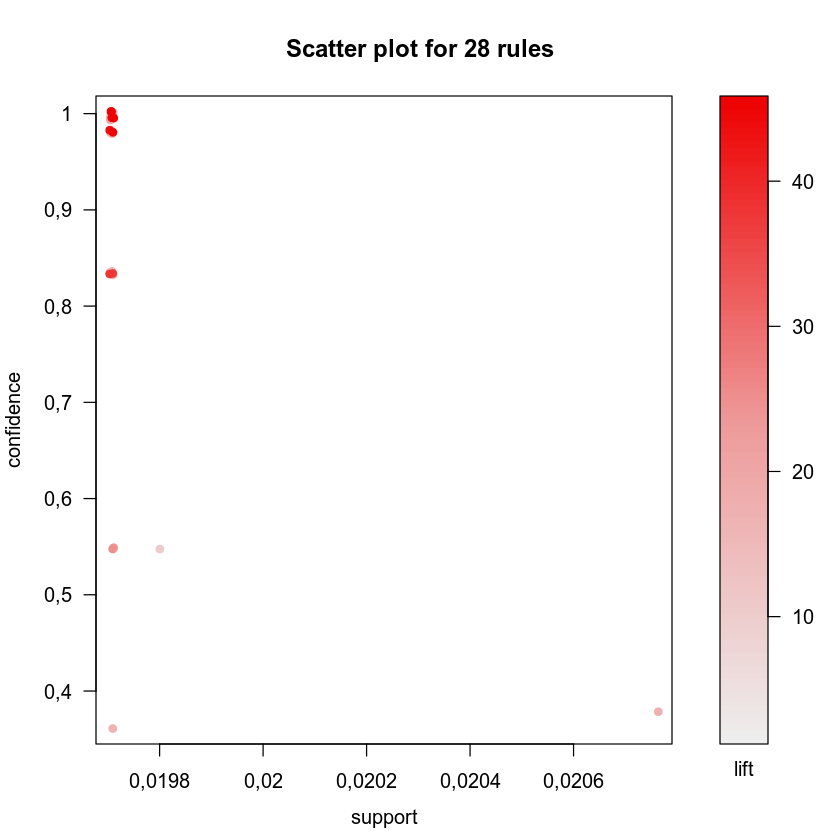

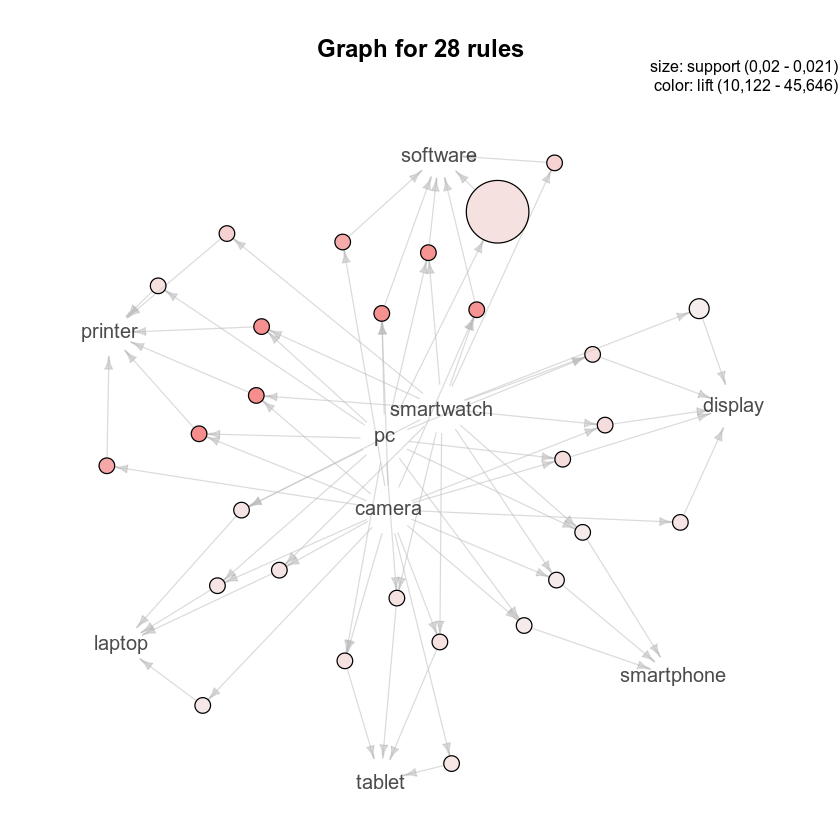

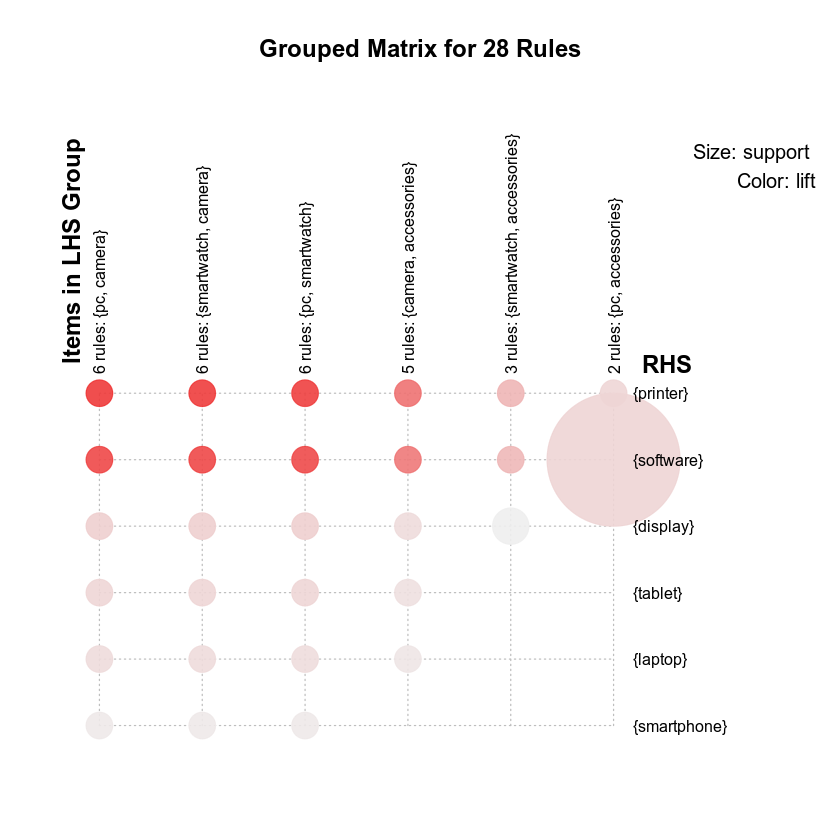

In [73]:
# Visualizing the rules
library(arulesViz)
plot(rules_multlev_high_profit_subset)
plot(rules_multlev_high_profit_subset, method='graph')
plot(rules_multlev_high_profit_subset, method='grouped matrix')